# Introduction to CRDS

## Prerequisites

To run the example code in this notebook, you must have the crds client library installed:

```
$ pip install crds==7.6.0
```

## What's a CRDS?

CRDS is a repository for reference files and a service that identifies the "best" reference files for a given dataset.  The acronym CRDS stands for:

**Calibration**: The data managed by CRDS (with a notable exception) are used with calibration software.

**Reference**: "Reference" data contrasts with the input dataset being calibrated.

**Data**: CRDS manages data in the form of files, both reference data files and CRDS's own configuration files.

**System**: CRDS is more than just a directory of files.  Its responsibilities require a client/server architecture, client-side caching, dynamic configuration, and more.

CRDS is generally pronounced "see-are-dee-ess" but I dare you to start referring to it as "curds".

## Great, so what's a reference file?

A reference file is any data besides the input dataset that the calibration pipeline needs in order to get its job done.  Some examples:

- Measurements of instrument characteristics needed to make a flat-field correction to a dataset.
- A set of default values for calibration pipeline parameters.
- Visit the [JWST CRDS website](https://jwst-crds.stsci.edu/) and expand the accordion buttons under "Operational References" to see many more.

CRDS supports the following reference file formats:

- ASDF (http://asdf-format.org)
- FITS (https://fits.gsfc.nasa.gov)
- JSON (https://www.json.org)
- YAML (https://yaml.org/)

## Why do we need a system to manage them?

One could imagine a simple arrangement of storing reference files on a shared filesystem in some well-defined directory structure.  What's wrong with that?

### Disciplined version control

For one thing, the reference files need to be strictly versioned.  Calibration software users need to be able to rely on consistent results, and if reference files are being updated in-place, they may see confusing differences from one run to the next.  Older versions of files need to be kept around, so that changes may be reverted in the event of a mistake.

CRDS enforces versioning -- once a file has been accepted into the system, it cannot be modified in-place.  Any update must be submitted as a new file, which is identified as superseding the old file but does not overwrite it.  This allows users to view the full history of changes to the file, and "rewind" back to an older version if necessary.    

### Validation

Another of CRDS's important functions is to check incoming reference files for correctness.  Each reference file type has a set of validations that are defined in the CRDS codebase, and CRDS will validate proposed updates to files and warn or reject them outright when the file content appears invalid.

### Documentation of changes

The CRDS web submission form requires that any changes to CRDS content be accompanied by extensive documentation, and will refuse to accept files when information is missing.

### Public access

The reference files need to be available to the wider community, which would not have access to an STScI shared filesystem.  The (ops) CRDS servers are open to the public and anyone can visit the website or install the client library and obtain reference files.

### Configuration vs. code

Finally, selecting the best reference file involves a navigating a complex set of rules that is unique to each reference file type.  Implementing these rules in the pipeline code isn't feasible, because reference files are updated far more regularly than software is released.  CRDS solves this problem by treating the rules themselves as data, versioning them alongside the reference files and allowing them to be dynamically configured via the CRDS website.

When a user requests the "best" reference file from CRDS, it consults the rules for the requested reference file type and returns the file that best suits the user's data.  We will spend the remainder of the notebook exploring this reference file selection function, which is mainly what CRDS end users are interested in.

## How reference files are selected

The following parameters are required in order to select the best reference file for a dataset:

### Observatory
The telescope for which the reference file is being selected.

Examples: `hst`, `jwst`
    
### Use case

The operational environment of a particular CRDS deployment.

Examples: `dev`, `test`, `ops`
    
### Context

An immutable state of reference data from which to select files.  Also a string identifier that refers to such a state.  The files associated with a given context will never change -- any time reference files are added, updated, or removed, a new context is created with a new identifier.  Think of this like a git tree hash.

Examples: `hst_0817.pmap`, `jwst_0641.pmap`

### Instrument

The instrument for which the reference file is being selected.

Examples: `cos`, `nircam`

### Reference file type

The type of reference file to be selected.

Examples: `readnoise`, `flat`
  
### Dataset metadata

Metadata from the dataset on which the reference file selection depends.  The exact subset of metadata fields required is dependent on the reference file type.

Examples: 

`META.INSTRUMENT.DETECTOR: NRCA2` (JWST style)

`DETECTOR: FUV` (HST style)

### Dataset observation timestamp

Metadata from the dataset on which time-dependent reference file selection depends.

Examples:

`META.OBSERVATION.DATE: 2018-05-03`, `META.OBSERVATION.TIME: 01:23:45` (JWST style)

`DATE-OBS: 2018-05-03`, `TIME-OBS: 01:23:45` (HST style)

## JWST pipeline seeks references for good times, flat fields

Here's a concrete example.  The JWST pipeline step `FlatFieldStep` applies a flat-field correction to an input file, and needs one or more reference files to do so.  Here is the list of reference file types that the step may need:

https://github.com/spacetelescope/jwst/blob/0.17.0/jwst/flatfield/flat_field_step.py#L51

```python
reference_file_types = ["flat", "fflat", "sflat", "dflat"]
```

Each of these strings is a reference file type identifier that CRDS has been configured to handle.  Later on in the `FlatFieldStep` class, we iterate over these types and request the best reference file of each type to be selected by CRDS:

https://github.com/spacetelescope/jwst/blob/0.17.0/jwst/flatfield/flat_field_step.py#L83

```python
reference_file_names = {}
for reftype in self.reference_file_types:
    reffile = self.get_reference_file(input_model, reftype)
    reference_file_names[reftype] = reffile if reffile != 'N/A' else None
```

where the `get_reference_file` method is defined on the `Step` base class.  Note that the input dataset is passed in alongside the reference file type so that metadata can be extracted and passed on to CRDS.

After a tortuous journey through the stpipe infrastructure, we end up here, calling a method on the `crds` client library:

https://github.com/spacetelescope/jwst/blob/0.17.0/jwst/stpipe/crds_client.py#L129

```python
bestrefs = crds.getreferences(
    data_dict, reftypes=reference_file_types, observatory=observatory)
```

The `data_dict` parameter is a `dict` of metadata keys and values that were extracted from the input dataset.  `reference_file_types` is a list of one type identifier, and `observatory` is set to `"jwst"`.

### Let's try it for ourselves...

Let's execute that call to `crds.getreferences` here in the notebook and see what we get back.  Since CRDS is used for multiple missions, we'll first need to configure it for JWST.  That is done with environment variables:

In [1]:
import os
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
os.environ["CRDS_PATH"] = os.path.join(os.environ["HOME"], "crds-tutorial-cache")
os.environ["CRDS_CONTEXT"] = "jwst_0641.pmap"

Then import the crds client library:

In [2]:
import crds

We know the observatory is `"jwst"`, and for this example let's request a reference file for the `"flat"` reference type:

In [3]:
observatory = "jwst"
reference_file_types = ["flat"]

We'll pretend that we're calibrating data for the `nircam` instrument.  For `nircam`, selection of the appropriate `flat` reference file depends on the detector, filter element, and pupil element used to capture the data, as well as the date and time of the observation.  So let's build a metadata dict that contains all of that information:

In [4]:
data_dict = {
    "META.INSTRUMENT.NAME": "NIRCAM",
    "META.INSTRUMENT.DETECTOR": "NRCA1",
    "META.INSTRUMENT.FILTER": "F140M",
    "META.INSTRUMENT.PUPIL": "WLM8",
    "META.OBSERVATION.DATE": "2014-06-23",
    "META.OBSERVATION.TIME": "11:43:15",    
}

Let's check back over the list of selection criteria above and make sure we have what we need:

**Observatory**: We've set the `observatory` parameter to `"jwst"`.

**Use case**: This is determined by the `CRDS_SERVER_URL` environment variable.  The URL we've chosen points to the JWST `ops` server.

**Context**: We've set the `CRDS_CONTEXT` environment variable to `jwst_0641.pmap`, which is the default context at time of writing.  It is not always necessary to set (or "pin") a specific context, but here we do it to ensure that this example produces a consistent result.

**Instrument**: The `META.INSTRUMENT.NAME` key in `data_dict` identifies the instrument.

**Reference file type**: We're requesting the `flat` reference file type.

**Dataset metadata**: We've provided values for `META.INSTRUMENT.DETECTOR`, `META.INSTRUMENT.FILTER`, and `META.INSTRUMENT.PUPIL`.  See below for explanation of how I knew those were required.

**Dataset observation timestamp**: We've provided values for `META.OBSERVATION.DATE` and `META.OBSERVATION.TIME`.

That's everything, now we can execute the call to `crds.getreferences` exactly as it's written in the JWST pipeline code.  The first time you run this you'll see a whole mess of output as the client downloads necessary files to your local cache.

In [5]:
bestrefs = crds.getreferences(
    data_dict, reftypes=reference_file_types, observatory=observatory)

Inspect what we got back:

In [6]:
bestrefs

{'flat': '/Users/eslavich/crds-tutorial-cache/references/jwst/nircam/jwst_nircam_flat_0296.fits'}

Look at that!  CRDS has identified the best reference file, downloaded it to your machine, and returned to you a local filesystem path.  The file really is available on disk:

In [7]:
!ls -l {bestrefs["flat"]}

-rw-r--r--  1 eslavich  1031  50359680 Sep 14 16:22 /Users/eslavich/crds-tutorial-cache/references/jwst/nircam/jwst_nircam_flat_0296.fits


The universe is a magical place.

### I don't believe in magic, how did CRDS actually know what file to return?

To answer that, we'll need to have a look at our CRDS server's "rules" files.  A rules file is a special type of file in the context that describes relationships between the context itself, the observatory's instruments, the reference file types, dataset metadata, and the reference files.  There are three subtypes of rules file:

- **.pmap** file: relates a single overall context to the many instruments supported in that context
- **.imap** file: relates a single instrument to the many reference file types supported for that instrument
- **.rmap** file: relates a single reference file type to dataset metadata and the many reference files supported for that reference file type

The rules files are arranged in a tree structure with a **.pmap** file at the top, **.imap** files descending from the **.pmap**, and **.rmap** files descending from each **.imap**.  Each context corresponds to one such tree, and since each tree contains only one **.pmap** file, the name of the **.pmap** file is used to identify the context.  That is why, up above, we set the `CRDS_CONTEXT` environment variable to `jwst_0641.pmap`.

The CRDS server, besides providing API services to the crds client package, also serves a website that can be used to explore these rules files.  The following URL shows the detail page for the `jwst_0641.pmap` context that we chose:

https://jwst-crds.stsci.edu/browse/jwst_0641.pmap

Expand the `Contents` accordion button to see the **.pmap** file in its entirety.  Its content is listed here:

```
header = {
    'asdf_standard_requirement' : '<1.5',
    'derived_from' : 'jwst_0640.pmap',
    'description' : 'Hand edited to add FGS, MIRI, NIRCAM, NIRISS PATHLOSS as N/A',
    'mapping' : 'PIPELINE',
    'name' : 'jwst_0641.pmap',
    'observatory' : 'JWST',
    'parkey' : ('META.INSTRUMENT.NAME',),
    'sha1sum' : '1f8e22ad17d419bb4b421724e9c566f312e0e858',
}

selector = {
    'FGS' : 'jwst_fgs_0082.imap',
    'MIRI' : 'jwst_miri_0206.imap',
    'NIRCAM' : 'jwst_nircam_0143.imap',
    'NIRISS' : 'jwst_niriss_0134.imap',
    'NIRSPEC' : 'jwst_nirspec_0209.imap',
    'SYSTEM' : 'jwst_system_0022.imap',
}
```

The format of a rules file is a Python script.  The script must create two variables, `header` and `selector`.  The `header` variable is set to a dict that contains metadata for the rules file itself.  The real meat of the file is in the `selector` variable, which here is a dict that maps keyword values to additional rules or reference files.  In this case the selector is showing relationships between JWST instrument names and **.imap** instrument-level rules files.

Note the `parkey` value in the `header` variable -- this tells CRDS to look for a key called `META.INSTRUMENT.NAME` in the data we passed to `crds.getreferences` above.  Our value for that key was `NIRCAM`, so as the CRDS client is fulfilling our request, it descends into the `jwst_nircam_0143.imap` rules file that is associated with that value.

Here's a link to that file's page:

https://jwst-crds.stsci.edu/browse/jwst_nircam_0143.imap

and its content partially listed here:

```
header = {
    'derived_from' : 'jwst_nircam_0142.imap',
    'instrument' : 'NIRCAM',
    'mapping' : 'INSTRUMENT',
    'name' : 'jwst_nircam_0143.imap',
    'observatory' : 'JWST',
    'parkey' : ('REFTYPE',),
    'sha1sum' : '856f2869600573187a3d538813fe648b52674291',
}

selector = {
    ...
    'FILTEROFFSET' : 'jwst_nircam_filteroffset_0003.rmap',
    'FLAT' : 'jwst_nircam_flat_0014.rmap',
    'FORE' : 'N/A',
    ...
}
```

Now the CRDS client performs a similar process with the reference type that we requested.  We specified `flat`, so it descends into the `jwst_nircam_flat_0014.rmap` rules file that is associated with that value (the selector keys are case-insensitive).

Here's a link to that file's page:

https://jwst-crds.stsci.edu/browse/jwst_nircam_flat_0014.rmap

and its content partially listed here:

```
header = {
    'classes' : ('Match', 'UseAfter'),
    'derived_from' : 'jwst_nircam_flat_0013.rmap',
    'filekind' : 'FLAT',
    'instrument' : 'NIRCAM',
    'mapping' : 'REFERENCE',
    'name' : 'jwst_nircam_flat_0014.rmap',
    'observatory' : 'JWST',
    'parkey' : (('META.INSTRUMENT.DETECTOR', 'META.INSTRUMENT.FILTER', 'META.INSTRUMENT.PUPIL'), ('META.OBSERVATION.DATE', 'META.OBSERVATION.TIME')),
    'sha1sum' : 'c8eecdcb1bb56df09144e9637d3cf87d0429160b',
}

selector = Match({
    ('NRCA1', 'F070W', 'CLEAR|WLP8|WLM8') : UseAfter({
        '2014-06-01 00:00:00' : 'jwst_nircam_flat_0383.fits',
    }),
    ('NRCA1', 'F090W', 'CLEAR') : UseAfter({
        '2014-06-01 00:00:00' : 'jwst_nircam_flat_0394.fits',
    }),
    ('NRCA1', 'F115W', 'CLEAR') : UseAfter({
        '2014-06-01 00:00:00' : 'jwst_nircam_flat_0319.fits',
    }),
    ('NRCA1', 'F140M', 'CLEAR|WLP8|WLM8|GDHS0|GDHS60') : UseAfter({
        '2014-06-01 00:00:00' : 'jwst_nircam_flat_0296.fits',
    }),
    ('NRCA1', 'F150W', 'CLEAR|WLP8|WLM8') : UseAfter({
        '2014-06-01 00:00:00' : 'jwst_nircam_flat_0347.fits',
    }),
    ...
}
```

The **.rmap** rules files are generally more complicated than the others, because their selectors often consider multiple dataset metadata values in combination.  Here we are matching on detector, filter, and pupil, and also requiring a minimum observation timestamp.  Our metadata values match only the fourth entry in the selector so CRDS can confidently return `jwst_nircam_flat_0296.fits` as the best reference file for our dataset.

The "parkey" header key is what told me which dataset metadata fields were required to select the reference file.  Note that each parkey value corresponds to an entry in the `data_dict` in the example code.

CRDS rules, particularly the **.rmap** files, are much more expressive and powerful than described here.  See the [CRDS User Manual](https://jwst-crds.stsci.edu/static/users_guide/rmap_syntax.html) for more information.

## CRDS from 20,000 feet

Now that we've seen a real example of how CRDS is used, let's briefly review the major components of the system that we just encountered.  Other CRDS system configurations are possible (and common) but this is the configuration utilized by this notebook.

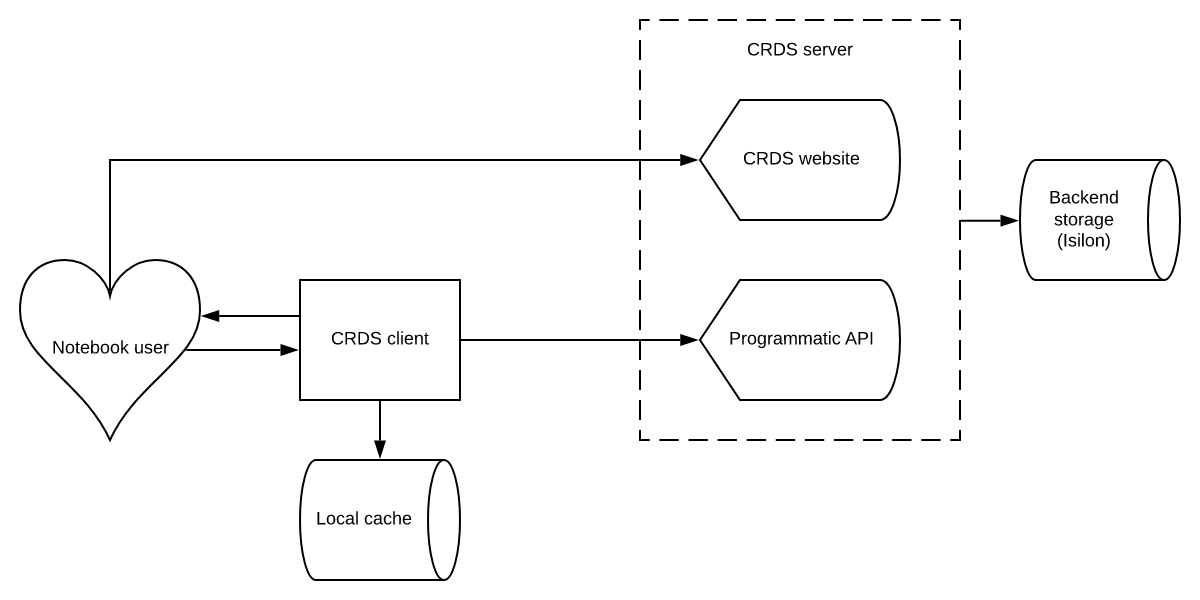

### Selecting best references

When we called the `crds.getreferences` client library method, the client code made an API request to the CRDS server with the parameters that we supplied.  The server determined the best reference file based on the rules in our chosen context and returned that information to the client in the form of a filename.

Next, the client checked its local on-disk cache for the presence of that file.  When the file was discovered to be missing, the client made an additional request to the CRDS server to fetch the file content.  The server read the content from its own storage area and transmitted the bytes over HTTP back to the client.  The client then created the file in its local cache and returned to us a filesystem path to that location.

If we were to make another call to `crds.getreferences` with the same parameters, the client would still make that initial API request, but because the file had previously been cached, it would not need to download the reference file content again.

### Visiting the CRDS website

When we followed a link to a rules file page, the page was served up by that same CRDS server.  The server read the rules file content from its storage area and transformed it into a convenient web format.  In addition to conveniences like browsing files, the CRDS website also provides the main method of submitting new reference files and rule changes.  The process of submitting files will be described in a subsequent notebook.

## Further reading

The excellent CRDS User Manual served as the primary source for much of this notebook:

https://jwst-crds.stsci.edu/static/users_guide/index.html